# PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões (2022)

Autor: Pedro H. G. Cazelatto

## Bibliotecas

Importando as bibliotecas necessárias para a execução do código.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## Dados

Importando os dados necessários para o treino e teste.

In [28]:
trainData = pd.read_csv(
    "../input/adult-pmr3508/train_data.csv",
    na_values= '?',
    index_col= ['Id'],
    header= 0,
    names= [
        "Id",
        "Age",
        "Workclass",
        "Fnlwgt",
        "Education",
        "Education-num",
        "Marital-status",
        "Occupation",
        "Relationship",
        "Race",
        "Sex",
        "Capital-gain",
        "Capital-loss",
        "Hours-per-week",
        "Native-country",
        "Target"
    ]
)

## Análise dos Dados

Antes de conseguir treinar alguma coisa, é necessário analisar os dados disponíveis e tratá-los.

Primeiro analisarei os dados categóricos e converterei-os em numéricos, através de One Hot Encoding ou Binary Encoding, a depender do dado.

In [29]:
trainData.describe(include= ['O'])

,Workclass,Education,Marital-status,Occupation,Relationship,Race,Sex,Native-country,Target
count,30724,32560,32560,30717,32560,32560,32560,31977,32560
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


A princípio, a coluna **Education** pode ser removida, pois já há uma correspondente numérica, a **Education-num**.

In [30]:
trainData.drop("Education", axis= 1, inplace= True)

As colunas **Workclass**, **Occupation** e **Native-country** possuem dados faltantes, então começarei por elas.

Para as outras colunas, vamos analisar caso a caso.

### Workclass

Faltam 1836 dados na coluna Workclass


<AxesSubplot: >

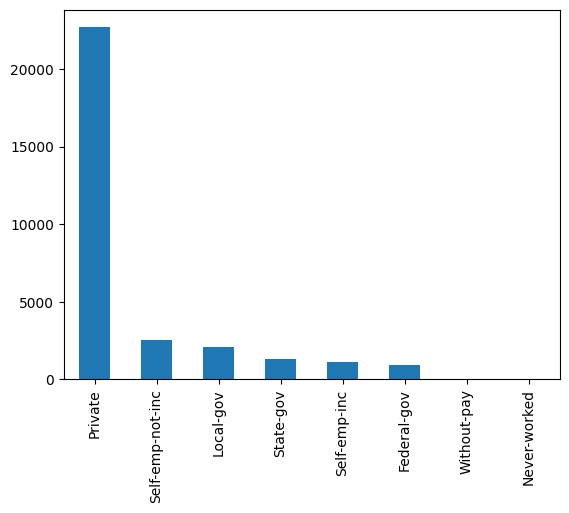

In [33]:
print("Faltam " + str(trainData["Workclass"].isnull().sum()) + " dados na coluna Workclass")
trainData["Workclass"].value_counts().plot(kind= "bar")

Como esta categoria possui a maioria de seus rótulos como *Private*, classificar os dados faltantes com a moda é uma boa estratégia.

In [34]:
trainData["Workclass"].fillna("Private", inplace= True)

Com a grande discrepância entre *Private* e os outros rótulos, farei tal agrupamento de maneira numérica trocando a coluna para **isPrivate**, colocando 0 em outras classes de trabalho.

<AxesSubplot: >

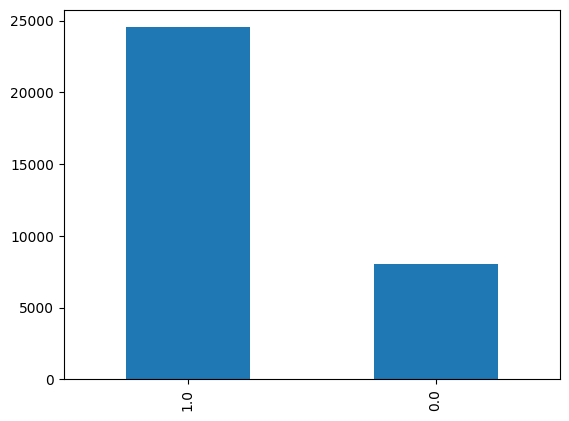

In [35]:
trainData.loc[trainData["Workclass"] != "Private", "Workclass"] = 0
trainData.loc[trainData["Workclass"] == "Private", "Workclass"] = 1
trainData["Workclass"] = trainData["Workclass"].astype(float)
trainData.rename(columns= {"Workclass": "isPrivate"}, inplace= True)

### Occupation

Faltam 1843 dados na coluna Occupation


<AxesSubplot: >

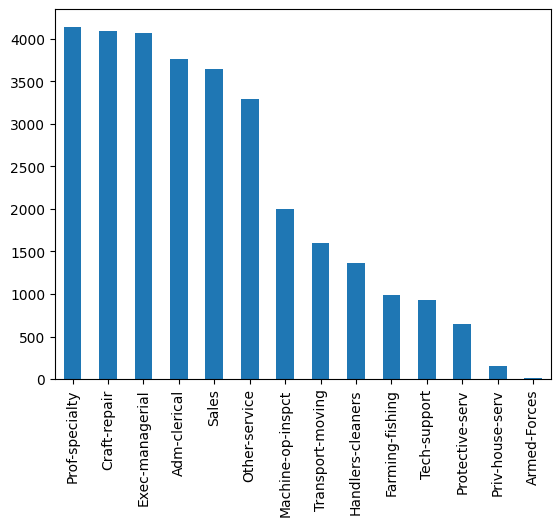

In [36]:
print("Faltam " + str(trainData["Occupation"].isnull().sum()) + " dados na coluna Occupation")
trainData["Occupation"].value_counts().plot(kind= "bar")

Na categoria **Occupation**, não é possível utilizar a moda, pois os três valores mais frequentes estão muito próximos. A princípio irei excluir os dados faltantes e reclassificarei os dados usando One Hot Encoding.

In [37]:
trainData["Occupation"].dropna(inplace= True)

In [38]:
trainData = pd.concat([trainData, pd.get_dummies(trainData["Occupation"], prefix= "Occ")], axis= 1)
trainData.drop("Occupation", axis= 1, inplace= True)

### Native-country

Faltam 583 dados na coluna Native-country


<AxesSubplot: >

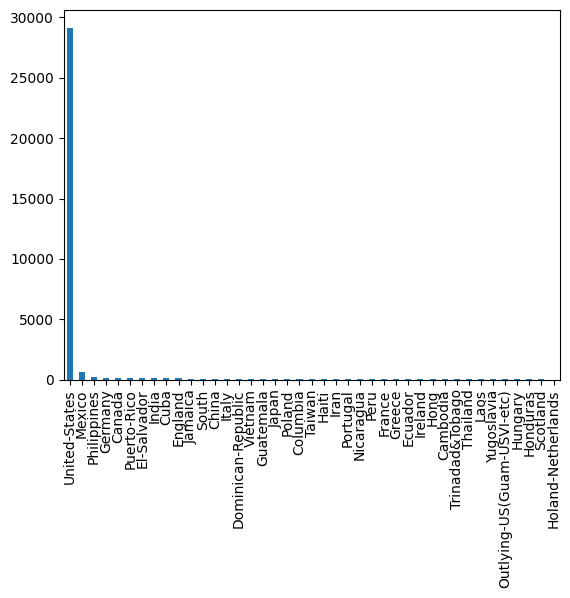

In [39]:
print("Faltam " + str(trainData["Native-country"].isnull().sum()) + " dados na coluna Native-country")
trainData["Native-country"].value_counts().plot(kind= "bar")

O primeiro ponto com a coluna **Native-country** será unificar os dados diferentes de *United-States*, pois tem quantidades muito pequenas, e transformar a coluna em binária **isFromUS**.

Levando em conta a forte cultura patriótica estadunidense, penso que aqueles que se recusaram a responder a nacionalidade no censo provavelmente são imigrantes, portanto completarei os dados com 0.

In [160]:
trainData.loc[trainData["Native-country"] != "United-States", "Native-country"] = 0
trainData.loc[trainData["Native-country"] == "United-States", "Native-country"] = 1
trainData["Native-country"] = trainData["Native-country"].astype(float)
trainData.rename(columns={"Native-country": "isFromUS"}, inplace= True)

KeyError: 'Native-country'

### Marital-status, Relationship & Race

<AxesSubplot: title={'center': 'Race'}>

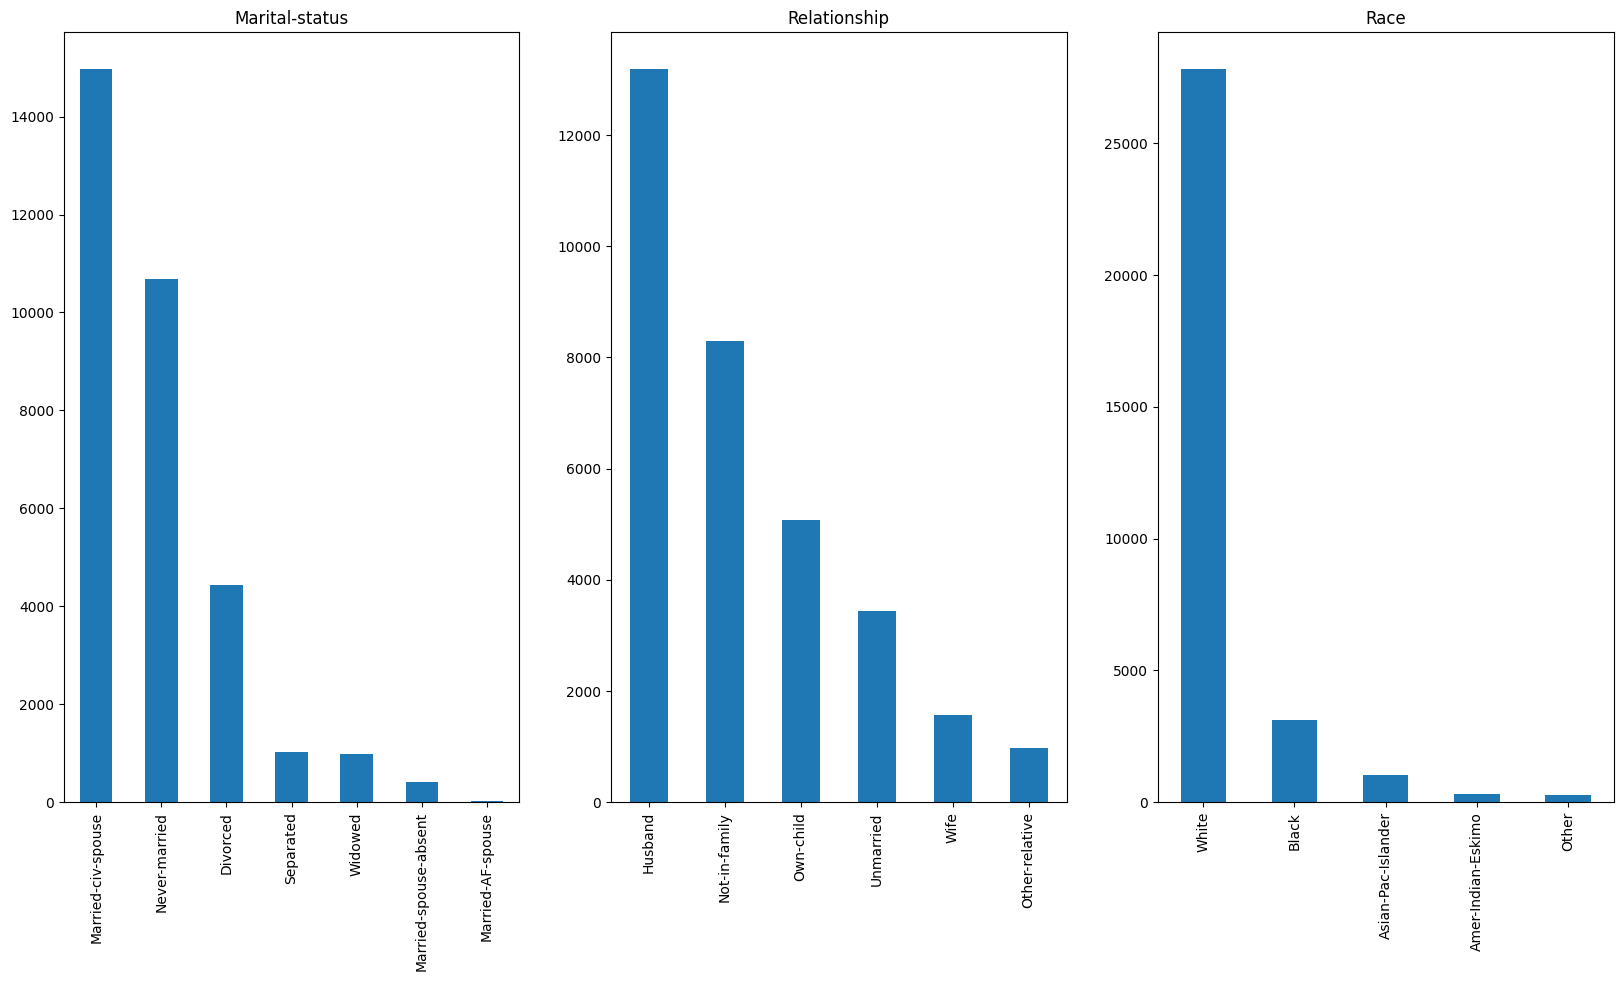

In [41]:
fig, axis = plt.subplots(nrows= 1, ncols= 3)
trainData["Marital-status"].value_counts().plot(kind= "bar", ax= axis[0], title= "Marital-status", figsize=(20,10))
trainData["Relationship"].value_counts().plot(kind= "bar", ax= axis[1], title= "Relationship")
trainData["Race"].value_counts().plot(kind= "bar", ax= axis[2], title= "Race")

Irei apenas recodificá-las com One Hot Encoding

In [42]:
trainData = pd.concat([trainData, pd.get_dummies(trainData["Marital-status"], prefix= "Mar")], axis= 1)
trainData = pd.concat([trainData, pd.get_dummies(trainData["Relationship"], prefix= "Rel")], axis= 1)
trainData = pd.concat([trainData, pd.get_dummies(trainData["Race"], prefix= "Rac")], axis= 1)
trainData.drop("Marital-status", axis= 1, inplace= True)
trainData.drop("Relationship", axis= 1, inplace= True)
trainData.drop("Race", axis= 1, inplace= True)

### Sex & Target

Tais categorias possuem apenas dois valores únicos, então tornarei suas variáveis binárias.

In [43]:
trainData.loc[trainData["Sex"] != "Male", "Sex"] = 0.0
trainData.loc[trainData["Sex"] == "Male", "Sex"] = 1.0
trainData["Sex"] = trainData["Sex"].astype(float)
trainData.rename(columns={"Sex": "isMale"}, inplace= True)
trainData.loc[trainData["Target"] != ">50K", "Target"] = 0
trainData.loc[trainData["Target"] == ">50K", "Target"] = 1
trainData["Target"] = trainData["Target"].astype(float)

### Correlação entre os dados

Calculo então a correlação absoluta entre os dados e a categoria **Target**, de modo a filtrar os dados relevantes.

<AxesSubplot: >

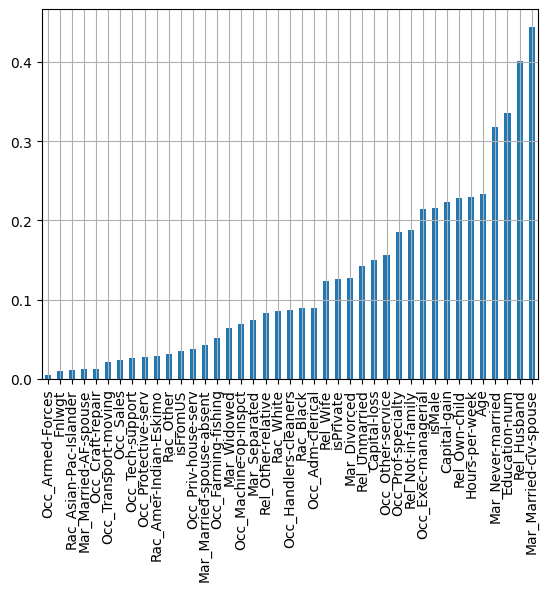

In [161]:
correlation = trainData.corr()
correlation.drop("Target", axis = 0, inplace= True)
correlation["Target"].abs().sort_values().plot(kind= "bar", grid= True)